# Implement a convolution estimator for the mnist problem


In [ ]:
# Source: https://github.com/ibab/tensorflow-wavenet/blob/master/wavenet/ops.py

def time_to_batch(value, dilation, name=None):
    with tf.name_scope('time_to_batch'):
        shape = tf.shape(value)
        pad_elements = dilation - 1 - (shape[1] + dilation - 1) % dilation
        padded = tf.pad(value, [[0, 0], [0, pad_elements], [0, 0]])
        reshaped = tf.reshape(padded, [-1, dilation, shape[2]])
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        return tf.reshape(transposed, [shape[0] * dilation, -1, shape[2]])


def batch_to_time(value, dilation, name=None):
    with tf.name_scope('batch_to_time'):
        shape = tf.shape(value)
        prepared = tf.reshape(value, [dilation, -1, shape[2]])
        transposed = tf.transpose(prepared, perm=[1, 0, 2])
        return tf.reshape(transposed,
                          [tf.div(shape[0], dilation), -1, shape[2]])

def causal_conv(value, filter_, dilation, name='causal_conv'):
    with tf.name_scope(name):
        filter_width = tf.shape(filter_)[0]
        if dilation > 1:
            transformed = time_to_batch(value, dilation)
            conv = tf.nn.conv1d(transformed, filter_, stride=1,
                                padding='VALID')
            restored = batch_to_time(conv, dilation)
        else:
            restored = tf.nn.conv1d(value, filter_, stride=1, padding='VALID')
        # Remove excess elements at the end.
        out_width = tf.shape(value)[1] - (filter_width - 1) * dilation
        result = tf.slice(restored,
                          [0, 0, 0],
                          [-1, out_width, -1])
        return result


In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse

from skimage.io import imread, imsave, imshow
from sklearn.model_selection import train_test_split

np.random.seed(111)


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:
(X_trn, y_trn), (X_tst, y_tst) = tf.keras.datasets.mnist.load_data(path='/tmp/mnist.npz')

#X_trn = np.array(X_trn/255.0, dtype=np.float32)
#y_trn = np.array(y_trn, dtype=np.int32)


In [7]:
a = np.zeros([5,5])

np.transpose(np.array([a]+[a]+[a]), (2,1,0)).shape

(5, 5, 3)

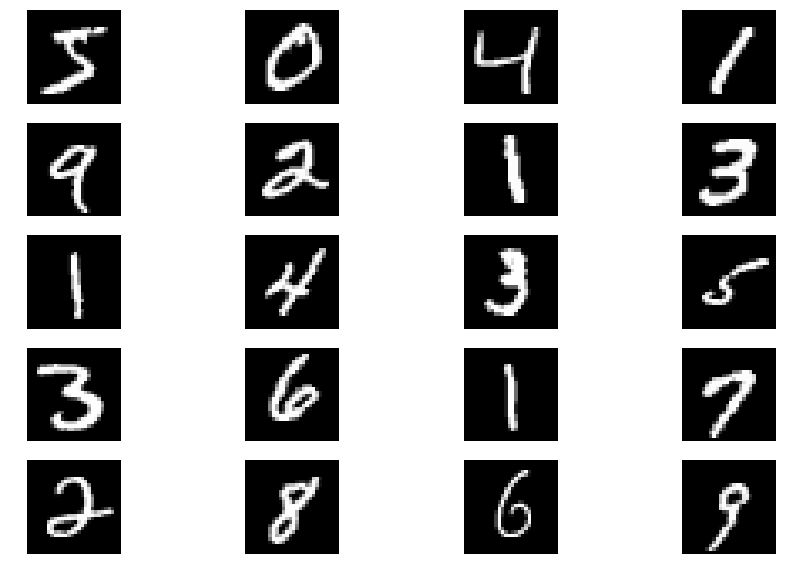

In [5]:
# Plot some images
%matplotlib inline

f, ax = plt.subplots(5,4, figsize=(15,10))

for i, img in enumerate(X_trn[:20]):
    ax[i//4, i%4].imshow(img, cmap='gray')
    ax[i//4, i%4].axis('off')
plt.show()  

In [6]:
# Define the train and eval datasets
# From https://github.com/tensorflow/models/blob/master/samples/core/get_started/iris_data.py

def decode_image(image):
    # Normalize from [0, 255] to [0.0, 1.0]
    image = tf.cast(image, tf.float32)
    return image / 255.0

def decode_label(label):
    label = tf.cast(label, tf.int32)
    return label


def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    inputs = features

    # Convert the inputs to a Dataset.
    ds_images = tf.data.Dataset.from_tensor_slices(inputs).map(decode_image)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels).map(decode_label)
    dataset = tf.data.Dataset.zip((ds_images, ds_labels))
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache().shuffle(buffer_size=1000).repeat().batch(batch_size)

    # GEnerate iterator and return the next elements of the iterator
    # in 1.6 yand above ou can pass directly the dataset and the estimator build internaly the iterator.
    (images, labels) = dataset.make_one_shot_iterator().get_next()
    return (images, labels)


def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    
    inputs = features
    ds_images = tf.data.Dataset.from_tensor_slices(inputs).map(decode_image)

    if labels is None:
        dataset = ds_images
    else:
        ds_labels = tf.data.Dataset.from_tensor_slices(labels).map(decode_label)
        dataset = tf.data.Dataset.zip((ds_images, ds_labels))

    # Batch the examples
    dataset = dataset.batch(batch_size)

    (images, labels) = dataset.make_one_shot_iterator().get_next()
    
    return (images, labels)





In [ ]:

class Model(tf.keras.models.Model):
  """Model to recognize digits in the MNIST dataset.
  """

  def __init__(self):
        
    # Define layers to use in the model
    self._input_shape = [-1, 28, 28, 1]

    self.conv1 = tf.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu)
    self.max_pool2d = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
    
    self.conv2 = tf.layers.Conv2D(64, 5, padding='same', activation=tf.nn.relu)
    
    self.fc1 = tf.layers.Dense(1024, activation=tf.nn.relu)
    self.dropout = tf.layers.Dropout(0.4)
    
    self.fc2 = tf.layers.Dense(10)

    
  def __call__(self, inputs, training):
    """Add operations to classify a batch of input images.
    Args:
      inputs: A Tensor representing a batch of input images.
      training: A boolean. Set to True to add operations required only when
        training the classifier.
    Returns:
      A logits Tensor with shape [<batch_size>, 10].
    """
    y = tf.reshape(inputs, self._input_shape)
    y = self.conv1(y)
    y = self.max_pool2d(y)
    y = self.conv2(y)
    y = self.max_pool2d(y)
    y = tf.layers.flatten(y)
    y = self.fc1(y)
    y = self.dropout(y, training=training)
    return self.fc2(y)



In [ ]:

class Model(tf.keras.models.Model):
  """Model to recognize digits in the MNIST dataset.
  """

  def __init__(self):
        
    # Define layers to use in the model
    self._input_shape = [-1, 28, 28]

    self.conv1 = tf.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu)
    self.max_pool2d = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
    
    self.conv2 = tf.layers.Conv2D(64, 5, padding='same', activation=tf.nn.relu)
    
    self.fc1 = tf.layers.Dense(1024, activation=tf.nn.relu)
    self.dropout = tf.layers.Dropout(0.4)
    
    self.fc2 = tf.layers.Dense(10)

    
  def __call__(self, inputs, training):
    """Add operations to classify a batch of input images.
    Args:
      inputs: A Tensor representing a batch of input images.
      training: A boolean. Set to True to add operations required only when
        training the classifier.
    Returns:
      A logits Tensor with shape [<batch_size>, 10].
    """
    y = tf.reshape(inputs, self._input_shape)
    
    y = causal_conv(y, filter_, dilation, name='causal_conv')
    
    y = self.conv1(y)
    y = self.max_pool2d(y)
    y = self.conv2(y)
    y = self.max_pool2d(y)
    y = tf.layers.flatten(y)
    y = self.fc1(y)
    y = self.dropout(y, training=training)
    return self.fc2(y)



In [7]:
# Define the model


# Define the model_function compatible with tf.estimators
def model_fn(features, labels, mode, params):
  """The model_fn argument for creating an Estimator."""
  image = features
  if isinstance(image, dict):
    image = features['image']
    
  # Instanciate the model
  model = Model()
    

  # Train step
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

    logits = model(image, training=True)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    accuracy = tf.metrics.accuracy(labels=labels, predictions=tf.argmax(logits, axis=1))
    
    # Name the accuracy tensor 'train_accuracy' to demonstrate the
    # LoggingTensorHook.
    tf.identity(accuracy[1], name='train_accuracy')
    
    tf.summary.scalar('train_accuracy', accuracy[1])
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.TRAIN,
        loss=loss,
        train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))



  if mode == tf.estimator.ModeKeys.EVAL:
    logits = model(image, training=False)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.EVAL,
        loss=loss,
        eval_metric_ops={
            'accuracy':
                tf.metrics.accuracy(
                    labels=labels,
                    predictions=tf.argmax(logits, axis=1)),
        })


  if mode == tf.estimator.ModeKeys.PREDICT:
    logits = model(image, training=False)
    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits),
    }
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.PREDICT,
        predictions=predictions,
        export_outputs={
            'classify': tf.estimator.export.PredictOutput(predictions)
        })



In [8]:
def main(unused_argv):
    
    # Create classifier
    mnist_classifier = tf.estimator.Estimator(
          model_fn=model_fn,
          model_dir='/tmp/mnist',
          params={})

    # Set up training hook that logs the training accuracy every 100 steps.
    tensors_to_log = {'train_accuracy': 'train_accuracy'}
    logging_hook = tf.train.LoggingTensorHook(
          tensors=tensors_to_log, every_n_iter=10)

    # Train the model
    mnist_classifier.train(input_fn=lambda:train_input_fn(X_trn, y_trn, FLAGS.batch_size),
                           hooks=[logging_hook], max_steps=FLAGS.train_steps)

    
    # Evaluate the model and print results
    eval_results = mnist_classifier.evaluate(input_fn=lambda:eval_input_fn(X_tst, y_tst, FLAGS.batch_size))
    print()
    print('Evaluation results:\n\t%s' % eval_results)

    # Export the model
    image = tf.placeholder(tf.float32, [None, 28, 28, 1])
    input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({'image': image})
    mnist_classifier.export_savedmodel('/tmp/mnist_model/', input_fn)
    
#tf.estimator.Estimator.export_savedmodel()    
    

if __name__ == '__main__':
    
    # Define the arguments of the program
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', default=32, type=int, help='batch size')
    parser.add_argument('--train_steps', default=100, type=int,
                        help='number of training steps')

    tf.logging.set_verbosity(tf.logging.INFO)
    FLAGS, unparsed = parser.parse_known_args()
    
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_model_dir': '/tmp/mnist', '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_steps': None, '_is_chief': True, '_task_id': 0, '_service': None, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2b7c297eb8>, '_session_config': None, '_task_type': 'worker', '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Starting evaluation at 2018-03-08-07:09:38
INFO:tensorflow:Restoring parameters from /tmp/mnist/model.ckpt-100
INFO:tensorflow:Finished evaluation at 2018-03-08-07:09:42
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.8629, global_step = 100, loss = 0.513538

Evaluation results:
	{'accuracy': 0.86290002, 'global_step': 100, 'l

SystemExit: 

/home/jorge/anaconda3/envs/tf14/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
